# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP-SVM-YOUR-SURNAME.ipynb') to Ecampus before the deadline.


**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule). 

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)

Features are computed using *manually checked segmentations* and following *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

First load all necessary packages

In [1]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Then load the data from my Google Drive

In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='18hrQVGBCfW7SKTnzmWUONo8iowBsi1DL',
dest_path='./data/features.csv')
gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
dest_path='./data/im/nevus-seg.jpg')
gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
dest_path='./data/im/nevus.jpg')
gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
dest_path='./data/im/melanoma-seg.jpg')
gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
dest_path='./data/im/melanoma.jpg')

ModuleNotFoundError: No module named 'google_drive_downloader'

Or from yout local computer. Please download the 'data' folder in the same folder as your notebook and do not modifiy it.

Then read the data 

In [5]:
## Read data
Working_directory="./data/" 
df = pd.read_csv(Working_directory + 'features.csv') # reading data
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))


Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115


Two examples of healthy nevus and melanoma


Text(0.5, 1.0, 'Segmented melanoma')

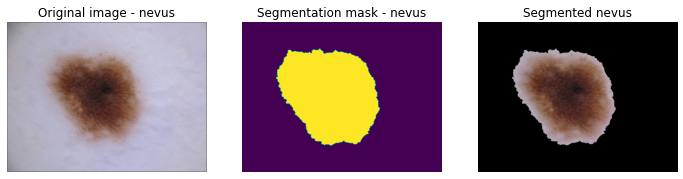

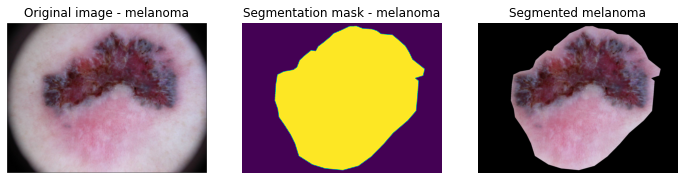

In [6]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread(Working_directory + 'im/nevus.jpg')
nevus_Segmentation = imread(Working_directory + 'im/nevus-seg.jpg') 
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")

###

melanoma = imread(Working_directory + 'im/melanoma.jpg')
melanoma_Segmentation = imread(Working_directory + 'im/melanoma-seg.jpg') 
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")


Now, as in the previous practical session you should shuffle the data randomly

In [7]:
# Shuffle data randomly

index = np.arange(0,N)
np.random.shuffle(index)
Xp=X[index]
yp=y[index]

We should now test the discriminative power of our features. Fist, let divide the entire data-set into training and test set using the `stratify` option. This will preserve the original proportion between nevus and melanoma also in the training and test set. You can check that from the plot.

Text(0, 0.5, 'Proportion')

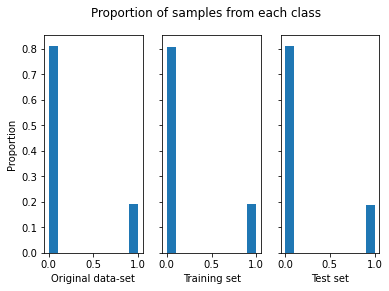

In [8]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(Xp, yp, test_size=0.3, random_state=42,stratify=yp)

fig, axs = plt.subplots(1, 3, sharey=True)
fig.suptitle('Proportion of samples from each class')
axs[0].hist(yp,weights=np.ones_like(yp)/len(yp))
axs[0].set_xlabel('Original data-set')
axs[1].hist(y_train,weights=np.ones_like(y_train)/len(y_train))
axs[1].set_xlabel('Training set')
axs[2].hist(y_test,weights=np.ones_like(y_test)/len(y_test))
axs[2].set_xlabel('Test set')
axs[0].set_ylabel('Proportion')

As we have already seen, it might be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance. Which is the right way of doing it when having a training and a test set in your opinion ? Should you use together both training and test set ?

Il vaut mieux séparer le dataset en train et test avant de le normaliser. Sinon, la moyenne utilisée pour la normalisation est celle de l'ensemble du dataset, et cela peut influencer nos résultats. On normalise donc les deux parties à l'aide d'un scaler, que l'on a préablement fit sur X_train.

In [9]:
# Scale data (each feature will have average equal to 0 and unit variance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Now, use two simple classification algorithms, for instance LDA and QDA, and look at the confusion matrices. 

**Question**: Comment the results. 

**Answer**:

La LDA semble avoir des résultats un petit peu plus satisfaisants sur healthy et QDA sur melanoma au vu des matrices de confusion. La détection de malanoma est globalement mauvaise, celle de healthy plutôt bonne.

Fitting LDA to training set
              precision    recall  f1-score   support

           0       0.87      0.95      0.90       146
           1       0.62      0.38      0.47        34

    accuracy                           0.84       180
   macro avg       0.74      0.66      0.69       180
weighted avg       0.82      0.84      0.82       180

Normalized confusion matrix
[[0.94520548 0.05479452]
 [0.61764706 0.38235294]]


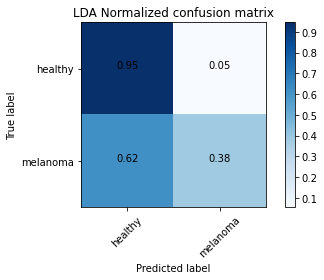

Fitting QDA to training set
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       146
           1       0.44      0.35      0.39        34

    accuracy                           0.79       180
   macro avg       0.65      0.63      0.63       180
weighted avg       0.78      0.79      0.79       180

Normalized confusion matrix
[[0.89726027 0.10273973]
 [0.64705882 0.35294118]]


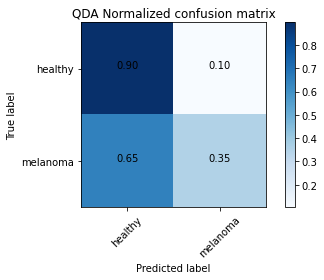

In [10]:
# Fitting LDA
print("Fitting LDA to training set")
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='LDA Normalized confusion matrix')
plt.show()

# Fitting QDA

print("Fitting QDA to training set")
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred = qda.predict(X_test)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='QDA Normalized confusion matrix')
plt.show()

The results you obtained are based on a precise subdivision of your data into training and test. This can thus bias your results. Which technique could you use instead ? Test it  with LDA, QDA and K-NN.

Nous pouvons réaliser une cross-validation.

In [11]:
# Fitting LDA
print("Fitting LDA")
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
lda_score = cross_val_score(lda,X=X_train,y= y_train,cv=10)
print("Moyenne : ",lda_score.mean())
print("Ecart-type : ", lda_score.std())
      
# Fitting QDA
print("Fitting QDA")
qda = make_pipeline(StandardScaler(), QuadraticDiscriminantAnalysis())
qda_score = cross_val_score(qda,X=X_train,y= y_train,cv=10)
print("Moyenne : ",qda_score.mean())
print("Ecart-type : ", qda_score.std())

# Fitting K-nearest neighbour
print("Fitting KNN")
knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))
knn_score = cross_val_score(knn,X=X_train,y= y_train,cv=10)
print("Moyenne : ",knn_score.mean())
print("Ecart-type : ", knn_score.std())

Fitting LDA
Moyenne :  0.7976190476190477
Ecart-type :  0.03238445359222726
Fitting QDA
Moyenne :  0.7952380952380953
Ecart-type :  0.04416008807378905
Fitting KNN
Moyenne :  0.819047619047619
Ecart-type :  0.02428104530282278


When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value using Cross Validation. Do it and plot the confusion matrix. Do you notice anything strange ? Why in your opinion do you have this kind of result ?

Les résultats de détection de mélanome sont plus mauvais qu'avant. Ici, on optimise le score global, et comme il y a probablement peu de mélanome, la détection de ces derniers est encore plus mauvaise. 

Best training Score: 0.8285714285714285
Best training params: {'n_neighbors': 2}
Normalized confusion matrix
[[0.95890411 0.04109589]
 [0.85294118 0.14705882]]


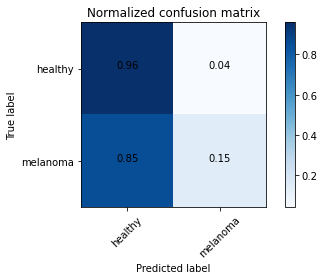

In [12]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In order to deal with this problem we have two possible solutions. 

**First**: Please look at this webpage (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) and try MORE APPROPRIATE scoring functions than accuracy when looking for the best K value of K-NN (thus within the Cross Validation as before..).

Best training Score: 0.39438434372644904
Best training params: {'n_neighbors': 1}
Normalized confusion matrix
[[0.8630137  0.1369863 ]
 [0.70588235 0.29411765]]


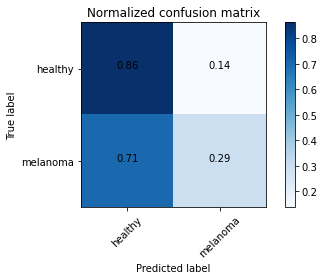

In [13]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="f1", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Second**: when dealing with such a problem (the one you should find !) a possible solution would be to oversample a class (which one in your opinion ?) Please look at this web page for more information (https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html) and try at least one naive random over-sampling (look at the following code...).

In [38]:
from imblearn.over_sampling import ADASYN
from collections import Counter
ros = ADASYN(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 339), (1, 354)]


Let's look for the best K in KNN (as before using Cross validation) but this time on the new training set. 

**Question**: Are the results better ? Do they change now if you modify the scoring function ? Why ?

Les résultats sont meilleurs et ne dépendent pas de la fonction de scoring. Ici, nous suréchantillonnons la classe du mélanome, cela permet de corriger le fait qu'elle soit sous représentée, et permet une meilleure détection.

Best training Score: 0.8787509123136275
Best training params: {'n_neighbors': 2}
Normalized confusion matrix
[[0.81506849 0.18493151]
 [0.61764706 0.38235294]]


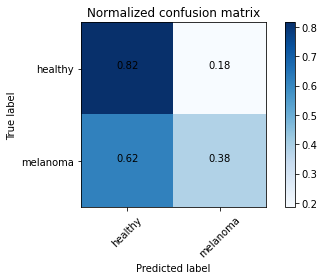

In [33]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_resampled,y_resampled)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Best training Score: 0.8885650231201183
Best training params: {'n_neighbors': 2}
Normalized confusion matrix
[[0.81506849 0.18493151]
 [0.61764706 0.38235294]]


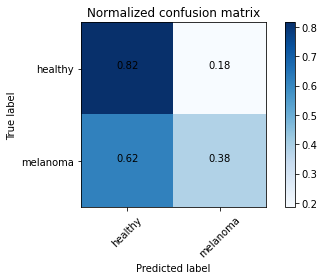

In [36]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="f1", cv=5)
grid_KNN.fit(X_resampled,y_resampled)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Let's use the techniques seen today: Perceptron and linear SVM. 

In [19]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_score'].mean(), Perc_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_score'].mean(), Perc_cv['test_score'].std() ))


# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_score'].mean(), Lsvm_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_score'].mean(), Lsvm_cv['test_score'].std() ))

Fitting Perceptron
 Average and std TRAIN CV accuracy : 0.56375 +- 0.28677020901372896
 Average and std TEST CV accuracy : 0.55 +- 0.2841165644981338
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8087500000000001 +- 0.0027638539919628232
 Average and std TEST CV accuracy : 0.8066666666666669 +- 0.0033333333333333214


We can easily use different scoring functions within the cross validate function of scikit-learn. Check the code.

In [20]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))


# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))


Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.56375 +- 0.28677020901372896
 Average and std TEST CV accuracy : 0.55 +- 0.2841165644981338
 Average and std TRAIN CV f1 : 0.2290990316398665 +- 0.14577425169699074
 Average and std TEST CV f1 : 0.18143711361102666 +- 0.14943241819718453
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.5700000000000001 +- 0.30133556876014483
 Average and std TEST CV accuracy : 0.555 +- 0.2967696450485161
 Average and std TRAIN CV f1 : 0.20286133050687294 +- 0.11175964540514785
 Average and std TEST CV f1 : 0.14295704295704298 +- 0.1482378800690168


**Question** Please do the same on the oversampled data and compare the results with the previous ones.

Les résultats sont bien meilleurs pour f1, et globalement les mêmes pour accuracy.


In [21]:
X_resampled_All, y_resampled_All = ros.fit_resample(Xp, yp)

# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,X_resampled_All, y_resampled_All,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))


# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,X_resampled_All, y_resampled_All,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.5948316645807259 +- 0.04458229439363488
 Average and std TEST CV accuracy : 0.5656281407035176 +- 0.032356685976715434
 Average and std TRAIN CV f1 : 0.6726592163887979 +- 0.03428995631935335
 Average and std TEST CV f1 : 0.6361848618542272 +- 0.09202455205741816
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.5560566332916145 +- 0.036450386716186826
 Average and std TEST CV accuracy : 0.5405527638190956 +- 0.014222428334877048
 Average and std TRAIN CV f1 : 0.6195500327871323 +- 0.14751115792494404
 Average and std TEST CV f1 : 0.6016878711518234 +- 0.1518855720845055


We can also ask to save the estimated models at each split (i.e. fold) with the option `return_estimator=True`. Using the perceptron, we will look for the best model using the oversampled training data and check the confusion matrix on the test data. 

**Question** Do it the same with the linear SVM.

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.5779295541028393 +- 0.07723277760029233
 Average and std TEST CV accuracy : 0.5786779272234386 +- 0.0703519715907878
 Average and std TRAIN CV f1 : 0.592902443790642 +- 0.08656142978853087
 Average and std TEST CV f1 : 0.5816416624039129 +- 0.08014834795189005
Normalized confusion matrix
[[0.51369863 0.48630137]
 [0.35294118 0.64705882]]


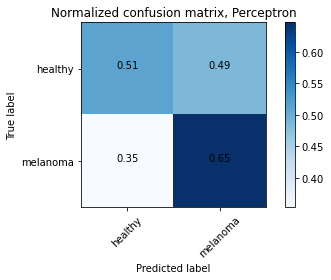

Fitting Linear SVM
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.7164477835235958 +- 0.01351139550812858
 Average and std TEST CV accuracy : 0.672463768115942 +- 0.04743820495552928
 Average and std TRAIN CV f1 : 0.7137142653116839 +- 0.014434013733877246
 Average and std TEST CV f1 : 0.6651104647955042 +- 0.06478443922759047
Normalized confusion matrix
[[0.63013699 0.36986301]
 [0.32352941 0.67647059]]


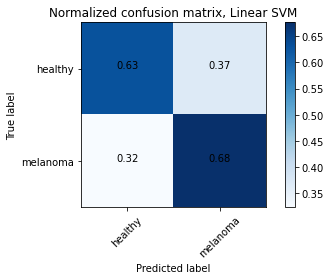

In [25]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,X_resampled, y_resampled,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
Perc_index_best = np.argmax(Perc_cv['test_accuracy'])
estimator_best=Perc_cv['estimator'][Perc_index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
Perc_cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(Perc_cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Perceptron')
plt.show()


# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,X_resampled, y_resampled,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(Lsvm_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
Lsvm_index_best = np.argmax(Lsvm_cv['test_accuracy'])
estimator_best=Lsvm_cv['estimator'][Lsvm_index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
Lsvm_cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(Lsvm_cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Linear SVM')
plt.show()

Suppose that there are overlapping classes, we need to set the hyper-parameter C for the SVM model. 

**Question** Use Cross-Validation on the oversampled data to find the best C value. Plot the confusion matrix using the best estimator (as before).

Best training Score: 0.6868939630903973
Best training params: {'C': 0.01}
Normalized confusion matrix
[[0.6369863  0.3630137 ]
 [0.32352941 0.67647059]]


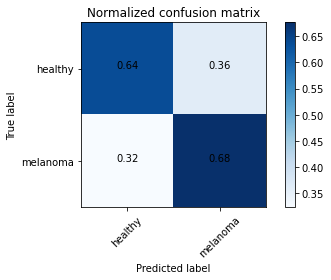

In [26]:
# Looking for the best hyperparameter C 
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC()
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="accuracy", cv=5)
grid_lsvm.fit(X_resampled,y_resampled)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
y_pred = grid_lsvm.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

**Question** Use Cross-Validation on the oversampled data to find the best C and $gamma$ value. Plot the confusion matrix using the best estimator (as before).

Fitting Non-linear SVM to the training set
Best training Score: 0.9639140861224064
Best training params: {'C': 4, 'gamma': 0.1}
Normalized confusion matrix
[[0.92465753 0.07534247]
 [0.76470588 0.23529412]]


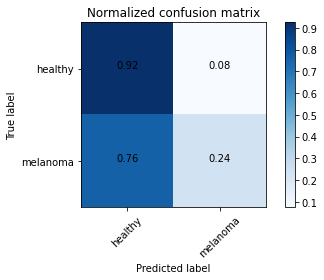

In [31]:
# Fitting Non-linear SVM with accuracy and oversampling
print("Fitting Non-linear SVM to the training set")
t0 = time()
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="accuracy", cv=5)
grid_nlsvm.fit(X_resampled,y_resampled)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
y_pred = grid_nlsvm.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Fitting Non-linear SVM to the training set
Best training Score: 0.9651105213520804
Best training params: {'C': 4, 'gamma': 0.1}
Normalized confusion matrix
[[0.92465753 0.07534247]
 [0.76470588 0.23529412]]


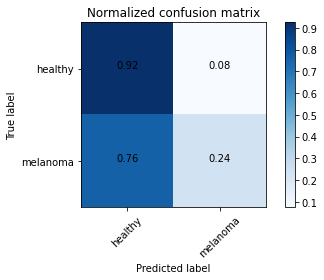

In [32]:
# Fitting Non-linear SVM with f1 and oversampling
print("Fitting Non-linear SVM to the training set")
t0 = time()
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="f1", cv=5)
grid_nlsvm.fit(X_resampled,y_resampled)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
y_pred = grid_nlsvm.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Question** Use the non-linear SVM with the two strategies seen before (different scoring function and/or oversampled data). Do the results change ? Why in your opinion ?

Les résultats ne dépendent pas de la fonction de scoring dans le cas où les données sont suréchantillonnées. Les résultats ne sont pas bons, on peut juger qu'il y a du surapprentissage.

**Question** Try to draw a conclusion from the different experiments. Which is the best method ? Which scoring function should you use ? Is it worth it to oversample one of the two classes ?

Au vu des résultats, je pense que les plus satisfaisants sont donnés pour la Cross-Validation sur les données suréchantillonnées et en optimisant C. En effet, On trouve les mélanomes dans 64% des cas sans que la détection de peau saine ne soit trop altérée (68%). L'objectif est de maximiser la détection des mélanomes, et le plus grand problème que nous rencontrons est le gros déséquilibre entre les deux classes (faible représentation des mélanomes). Ainsi, il est intéressant de surreprésenter les mélanomes pour améliorer la détection.

**OPTIONAL** Another interesting question is: what about the number of features ? Can we reduce the dimensionality ? You could use one of the techniques seen during the previous lectures (i.e. PCA) ...

In [ ]:
# Test PCA with a linear SVM
XXXXXXXX

In [ ]:
# Fitting Linear SVM 
XXXXXXXXXX

**OPTIONAL** ... or test the importance of the single features.
The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. Starting from an empty set and a classification model, you will first add the feature that maximizes a certain criterion (i.e. f1 score). Then, you will iterate this process until a chosen stopping criterion by adding at each iteration only the best feature. Each feature can be added of course only once. You could also use the opposite process by removing at each iteraton the least important feature starting from the entire set of features (i.e. sequential backward feature selection). Implement at least one of these ideas. 

In [ ]:
# Implement forward feature selection and/or backward feature selection
# with a linear SVM

XXXXXXXXXX